<a href="https://colab.research.google.com/github/MikeSoricelli/FeatureDistillation/blob/main/VectorQuantizedResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Todo

Try method on efficient architectures designed for edge devices

load in pretrained weights from another model for feature extraction within custom model with VQ layer (use resnet 9, pretrain the model and siave), laod in weights in init function

or

Try warmup phase, maybe schedule emdedded vector elarning aswell

In [1]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
import subprocess
import time

def get_gpu_power():
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,nounits,noheader']
    )
    return float(result)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import numpy as np

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes, input_sample, labels, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.num_classes = num_classes

        embeddings = np.array([], dtype=float).reshape(0, embedding_dim)

        for i in range(num_classes):
            class_indices = torch.where(labels == i)[0]
            class_samples = input_sample[class_indices]

            # Perform k-means clustering
            kmeans = KMeans(n_clusters=num_embeddings, random_state=42)

            # Reshape input_sample to 2D if it's not already
            if input_sample.dim() > 2:
                input_sample = input_sample.view(-1, embedding_dim)

            # Convert to numpy for sklearn
            input_sample_np = input_sample.detach().cpu().numpy()

            #can we do this by class, performing K means on the whole statset at once miught be increasing the runtime

            # Fit k-means
            kmeans.fit(input_sample_np)

            centroids = kmeans.cluster_centers_
            embeddings = np.append(embeddings, centroids, axis=0)



        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False)






    def forward(self, inputs, threshold):
        # inputs are expected to be of shape (batch_size, embedding_dim)

        batch_size = inputs.shape[0]


        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self.embedding.weight.t()))



        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings * self.num_classes, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)


        # Quantize
        quantized = torch.matmul(encodings, self.embedding.weight)


        # Loss
        # Compute per-example losses
        e_latent_loss = torch.sum((quantized.detach() - inputs)**2, dim=1)  # shape: (batch_size,)
        q_latent_loss = torch.sum((quantized - inputs.detach())**2, dim=1)  # shape: (batch_size,)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss  # shape: (batch_size,)
        avg_loss = loss.mean()

        print(avg_loss.item())

        # Determine if backpropagation should be halted
        halt_backprop_mask = avg_loss > threshold

        # print(loss)

        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()

        # Perplexity
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # assert halt_backprop_mask.shape == (batch_size,), f"Expected mask shape {(batch_size,)}, got {halt_backprop_mask.shape}"

        return quantized, halt_backprop_mask, loss


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import numpy as np

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes, commitment_cost=0.25, decay=0.99):
        super(VectorQuantizerEMA, self).__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.num_classes = num_classes
        self.decay = decay

        # Generate random embeddings for all classes at once
        total_embeddings = num_embeddings
        embeddings = np.random.randn(total_embeddings, embedding_dim)

        # Normalize the embeddings (optional, but often helpful)
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

        # Convert to PyTorch tensor
        embeddings_tensor = torch.from_numpy(embeddings).float()

        # Create the embedding layer
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, freeze=False)

        # If you want the embeddings to be trainable
        self.embedding.weight.requires_grad = False

        print(embeddings)

        # Initialize EMA-related buffers
        self.register_buffer('ema_cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('ema_w', self.embedding.weight.data.clone())
        self.register_buffer('ema_update_count', torch.tensor(0))



    def forward(self, inputs, threshold):
        # inputs are expected to be of shape (batch_size, embedding_dim)

        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self.embedding.weight.t()))


        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize
        quantized = torch.matmul(encodings, self.embedding.weight)


        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        avg_loss = loss.mean()


        # Determine if backpropagation should be halted
        halt_backprop = avg_loss > threshold


        # print(loss)
        self.ema_update(encodings, inputs)

        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()

        # Perplexity
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, halt_backprop, avg_loss

    def ema_inplace(self, moving_avg, new, decay):
        moving_avg.data = moving_avg.data * decay + new * (1 - decay)

    def ema_update(self, encodings, inputs):
        self.ema_update_count += 1

        # EMA update for cluster size
        self.ema_inplace(self.ema_cluster_size, encodings.sum(0), self.decay)

        # Laplace smoothing of the cluster size
        n = self.ema_cluster_size.sum()
        self.ema_cluster_size = (
            (self.ema_cluster_size + 1e-5) / (n + self.num_embeddings * self.num_classes * 1e-5) * n
        )

        # EMA update for embedding average
        dw = torch.matmul(encodings.t(), inputs)
        self.ema_inplace(self.ema_w, dw, self.decay)

        # Normalize embeddings
        self.embedding.weight.data = (
            self.ema_w / self.ema_cluster_size.unsqueeze(1)
        )

In [8]:
import torch
import torch.nn as nn

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes=10, input_size=32, num_embeddings=50):
        super().__init__()


        self.vq_layer = VectorQuantizerEMA(num_embeddings, 512, num_classes)
        self.loss = 0
        self.halt_backprop = False

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Linear(512, num_classes)
        self.fc1 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                        nn.Flatten(),
                                        )

    def forward(self, xb, threshold):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.fc1(out)
        x, self.halt_backprop, loss = self.vq_layer(out, threshold)
        self.loss = loss.item()
        out = self.classifier(out)
        return out

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
import torch.nn as nn

class ResNet18VQ(nn.Module):
    def __init__(self, in_channels, num_classes=10, input_size=32, num_embeddings=50):
        super().__init__()


        pretrained_model = torchvision.models.resnet18(pretrained=True)

        self.vq_layer = VectorQuantizerEMA(num_embeddings, 512, num_classes)
        self.loss = 0
        self.halt_backprop = False

        self.conv1 = pretrained_model.conv1
        self.bn1 = pretrained_model.bn1
        self.relu = pretrained_model.relu
        self.maxpool = pretrained_model.maxpool
        self.layer1 = pretrained_model.layer1
        self.layer2 = pretrained_model.layer2
        self.layer3 = pretrained_model.layer3
        self.layer4 = pretrained_model.layer4


        self.classifier = nn.Linear(512, num_classes)
        self.fc1 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                        nn.Flatten(),
                                        )

    def forward(self, xb, threshold):
        out = self.conv1(xb)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.conv2(out)
        out = self.fc1(out)
        x, self.halt_backprop, loss = self.vq_layer(out, threshold)
        self.loss = loss.item()
        out = self.classifier(out)
        return out

#Test on CIFAR10

In [ ]:
import time
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip()
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

train_dataset = datasets.CIFAR10(root='./data', download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

data_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
data_loader_test = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = torch.nn.CrossEntropyLoss()
model = ResNet18VQ(3, 10, 32, 100)  # Adjust input channels to 3, num_classes to 257, and input_size to 224

model = model.to(device)



optimizer = torch.optim.Adam([p for n, p in model.named_parameters() if 'vq_layer' not in n], lr=0.0001)

threshold = 100000
threshold_change = 1
prior_threshold = 0
threshold_current = 0

start_time = time.time()

count = 0
actcount = 0
traincount = 0
power_readings = []

epochs = 30

accuracy_list = np.zeros(epochs)

test_time_elapsed = 0


test_times = []

#trianing loop
for epoch in range(epochs):
    losses = []
    total_loss = 0
    model.train()

    for images, targets in data_loader:
        actcount += 1
        images = images.to(device)
        targets = targets.to(device)

        #pass threshold into model
        outputs = model(images, threshold)

        #if halt_backprop flag is set, skip backward pass
        if model.halt_backprop:
            count += 1
        else:
        traincount += 1
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

        losses.append(model.loss)
        power_readings.append(get_gpu_power())

    threshold setting
    if epoch > 4:
      prior_threshold = threshold_current
      threshold_current = np.quantile(np.array(losses), 0.5)

      #threshold projection
      if epoch > 5:
        threshold_change = threshold_current - prior_threshold
        threshold = threshold_current + threshold_change

    test_time = time.time()
    model.eval()

    correct = 0
    total = 0
    for images, targets in data_loader_test:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images, 1000)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    accuracy = correct / total
    accuracy_list[epoch] = accuracy
    print(f'Epoch: {epoch+1}, Accuracy: {accuracy}')


    print(f"trained:{traincount}, skipped:{count}, total:{actcount}")
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

    test_time_end = time.time()
    test_time_elapsed += test_time_end - test_time




end_time = time.time()
elapsed_time = end_time - start_time - test_time_elapsed
print(f"Elapsed time: {elapsed_time} seconds")

average_power = sum(power_readings) / len(power_readings)
total_energy = average_power * (elapsed_time) / 3600  # in watt-hours
print(f"Total energy consumed: {total_energy} kWh")

print(f"trained:{traincount}, skipped:{count}, total:{actcount}")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, targets in data_loader_test:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images, 1000)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    accuracy = correct / total
    print(f'Final Test Accuracy: {accuracy}')

#CIFAR100 Test

In [15]:
import time
import torchvision
from torchvision import transforms, datasets
#!!!!

# transform = transforms.Compose([
#     #transforms.Grayscale(3),  # Convert to 3 channels
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


weight_decay = 1e-4
epochs = 100
max_lr = 0.1
lr = 0.001
momentum = 0.9


VQ = True

CIFAR100 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

data_loader = DataLoader(dataset=CIFAR100, batch_size=512, shuffle=True, num_workers=6, pin_memory=True)

CIFAR100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

data_loader_test = DataLoader(dataset=CIFAR100_test, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

ratios = [0.5]


model = ResNet18VQ(3, 100, 32, 100)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)


for ratio in ratios:

  threshold = 100000

  threshold_change = 1

  prior_threshold = 0

  threshold_current = 0

  test_time = 0

  start_time = time.time()

  count = 0
  actcount= 0
  traincount = 0
  power_readings = []

  train_accuracies = []

  test_accuracies = []

  for epoch in range(100):
      losses = []
      for images, targets in data_loader:
          actcount += 1
          images = images.to(device)
          targets = targets.to(device)

          # outputs = model(images)
          outputs = model(images, threshold)

          if model.halt_backprop:
            count += 1
          else:
            traincount += 1
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          if VQ:
              losses.append(model.loss)
          power_readings.append(get_gpu_power())

      if VQ:
          prior_threshold = threshold_current
          threshold_current = np.quantile(np.array(losses), ratio)
          if epoch > 0:
            threshold_change = threshold_current - prior_threshold
            threshold = threshold_current + threshold_change
          model.lossCollection = []
          print(f"trained:{traincount}, skipped:{count}, total:{actcount}")
          print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

      start_test_time = time.time()
      correct = 0
      for images, targets in data_loader:
          images = images.to(device)
          targets = targets.to(device)
          #outputs = model(images)
          outputs = model(images, threshold)
          predicted = torch.argmax(outputs, dim=1)
          correct += (predicted == targets).sum().item()
      accuracy = correct / len(data_loader.dataset)
      print(f"Train Accuracy = {accuracy}")
      train_accuracies.append(accuracy)

      correct = 0
      for images, targets in data_loader_test:
          images = images.to(device)
          targets = targets.to(device)
          #outputs = model(images)
          outputs = model(images, threshold)
          predicted = torch.argmax(outputs, dim=1)
          correct += (predicted == targets).sum().item()
      accuracy = correct / len(data_loader_test.dataset)
      print(f"Test Accuracy = {accuracy}")
      test_accuracies.append(accuracy)
      end_test_time = time.time()
      test_time += end_test_time - start_test_time
  # Final summary


  end_time = time.time()
  elapsed_time = end_time - start_time - test_time
  print(f"Elapsed time: {elapsed_time} seconds")

  # End of your code block

  average_power = sum(power_readings) / len(power_readings)
  total_energy = average_power * (elapsed_time) / 3600  # in watt-hours
  print(f"Total energy consumed: {total_energy} kWh")
  print(f"Train accuracies: {train_accuracies}")
  print(f"Test accuracies: {test_accuracies}")

  print(f"trained:{traincount}, skipped:{count}, total:{actcount}")

  correct = 0
  for images, targets in data_loader_test:
      images = images.to(device)
      targets = targets.to(device)
      # outputs = model(images, 1000)
      outputs = model(images, 1000)
      predicted = torch.argmax(outputs, dim=1)
      correct += (predicted == targets).sum().item()

  accuracy = correct / len(data_loader_test.dataset)
  print(f'Accuracy: {accuracy}')

[[ 0.00654934 -0.02988261  0.03857945 ... -0.02873024 -0.06941183
  -0.02375779]
 [ 0.00105359  0.00668138  0.01140928 ... -0.00633289  0.02377027
   0.06152437]
 [ 0.00832162  0.00196361 -0.01803443 ...  0.00012224  0.10647504
   0.0146817 ]
 ...
 [-0.04369464  0.02244011  0.03291095 ...  0.00290482  0.0120253
   0.01644834]
 [ 0.07172272  0.02856952 -0.00788331 ...  0.04737565 -0.0216212
   0.03039889]
 [-0.02387148 -0.05209695 -0.00689018 ... -0.08158696  0.00341562
  -0.0168338 ]]
trained:98, skipped:0, total:98
Epoch: 1, Loss: 2.194058656692505
Train Accuracy = 0.41492
Test Accuracy = 0.371
trained:196, skipped:0, total:196
Epoch: 2, Loss: 1.968571424484253
Train Accuracy = 0.49006
Test Accuracy = 0.4159
trained:294, skipped:0, total:294
Epoch: 3, Loss: 1.9168508052825928
Train Accuracy = 0.53306
Test Accuracy = 0.4626
trained:294, skipped:98, total:392
Epoch: 4, Loss: 1.9168508052825928
Train Accuracy = 0.53534
Test Accuracy = 0.4583
trained:294, skipped:196, total:490
Epoch: 5, 

In [16]:
import time
import torchvision
from torchvision import transforms, datasets
#!!!!

# transform = transforms.Compose([
#     #transforms.Grayscale(3),  # Convert to 3 channels
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


weight_decay = 1e-4
epochs = 100
max_lr = 0.1
lr = 0.001
momentum = 0.9


VQ = True

CIFAR100 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

data_loader = DataLoader(dataset=CIFAR100, batch_size=512, shuffle=True, num_workers=6, pin_memory=True)

CIFAR100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

data_loader_test = DataLoader(dataset=CIFAR100_test, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

ratios = [0.5]


model = torchvision.models.resnet18(pretrained=True)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)


for ratio in ratios:

  threshold = 100000

  threshold_change = 1

  prior_threshold = 0

  threshold_current = 0

  test_time = 0

  start_time = time.time()

  count = 0
  actcount= 0
  traincount = 0
  power_readings = []

  train_accuracies = []

  test_accuracies = []

  for epoch in range(100):
      losses = []
      for images, targets in data_loader:
          actcount += 1
          images = images.to(device)
          targets = targets.to(device)

          # outputs = model(images)
          outputs = model(images)

          traincount += 1
          loss = criterion(outputs, targets)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          power_readings.append(get_gpu_power())

      start_test_time = time.time()
      correct = 0
      for images, targets in data_loader:
          images = images.to(device)
          targets = targets.to(device)
          #outputs = model(images)
          outputs = model(images)
          predicted = torch.argmax(outputs, dim=1)
          correct += (predicted == targets).sum().item()
      accuracy = correct / len(data_loader.dataset)
      print(f"Train Accuracy = {accuracy}")
      train_accuracies.append(accuracy)

      correct = 0
      for images, targets in data_loader_test:
          images = images.to(device)
          targets = targets.to(device)
          #outputs = model(images)
          outputs = model(images)
          predicted = torch.argmax(outputs, dim=1)
          correct += (predicted == targets).sum().item()
      accuracy = correct / len(data_loader_test.dataset)
      print(f"Test Accuracy = {accuracy}")
      test_accuracies.append(accuracy)
      end_test_time = time.time()
      test_time += end_test_time - start_test_time
  # Final summary


  end_time = time.time()
  elapsed_time = end_time - start_time - test_time
  print(f"Elapsed time: {elapsed_time} seconds")

  # End of your code block

  average_power = sum(power_readings) / len(power_readings)
  total_energy = average_power * (elapsed_time) / 3600  # in watt-hours
  print(f"Total energy consumed: {total_energy} kWh")
  print(f"Train accuracies: {train_accuracies}")
  print(f"Test accuracies: {test_accuracies}")

  correct = 0
  for images, targets in data_loader_test:
      images = images.to(device)
      targets = targets.to(device)
      # outputs = model(images, 1000)
      outputs = model(images, 1000)
      predicted = torch.argmax(outputs, dim=1)
      correct += (predicted == targets).sum().item()

  accuracy = correct / len(data_loader_test.dataset)
  print(f'Accuracy: {accuracy}')

100%|██████████| 169M/169M [00:02<00:00, 76.3MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Train Accuracy = 0.27674
Test Accuracy = 0.2471


KeyboardInterrupt: 

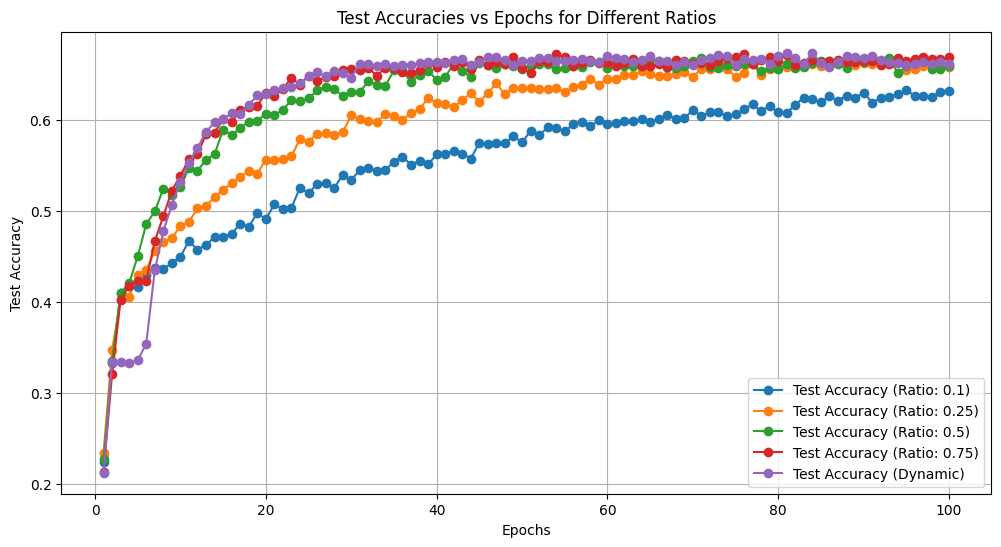

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Define the test accuracies for each ratio
test_accuracies_01 = [0.2239, 0.3325, 0.4097, 0.4177, 0.416, 0.4289, 0.4374, 0.4359, 0.4425, 0.4494, 0.4667, 0.4573, 0.4623, 0.4711, 0.4713, 0.4745, 0.4857, 0.4822, 0.4973, 0.4908, 0.5068, 0.5014, 0.5031, 0.5252, 0.5189, 0.5295, 0.5303, 0.5248, 0.5391, 0.5338, 0.5443, 0.5471, 0.5437, 0.5444, 0.5539, 0.5594, 0.5503, 0.5549, 0.5507, 0.5618, 0.5627, 0.5653, 0.5627, 0.557, 0.5746, 0.5734, 0.5743, 0.5738, 0.5819, 0.5749, 0.5875, 0.5825, 0.5914, 0.591, 0.5869, 0.5948, 0.5975, 0.5925, 0.5995, 0.5956, 0.5958, 0.5984, 0.5982, 0.6002, 0.5974, 0.6002, 0.6051, 0.6007, 0.6013, 0.6105, 0.604, 0.6079, 0.6081, 0.604, 0.6056, 0.6112, 0.6166, 0.6089, 0.6152, 0.6079, 0.6074, 0.6161, 0.6241, 0.6221, 0.6189, 0.6255, 0.6207, 0.6263, 0.6238, 0.6296, 0.6186, 0.6235, 0.6251, 0.6283, 0.6324, 0.6258, 0.626, 0.6251, 0.6305, 0.6317] # Fill in with the actual values from above
test_accuracies_025 = [0.2343, 0.347, 0.4025, 0.4053, 0.4299, 0.4351, 0.4557, 0.4657, 0.4699, 0.4831, 0.4879, 0.5024, 0.5049, 0.5152, 0.5229, 0.5301, 0.5369, 0.5436, 0.5405, 0.5561, 0.5556, 0.5569, 0.5597, 0.5788, 0.5757, 0.5846, 0.5847, 0.583, 0.5859, 0.6046, 0.6003, 0.5985, 0.5973, 0.6062, 0.6038, 0.5995, 0.6069, 0.6111, 0.6236, 0.6183, 0.6166, 0.614, 0.621, 0.629, 0.6194, 0.629, 0.6396, 0.6275, 0.6349, 0.6349, 0.6349, 0.633, 0.6336, 0.6351, 0.63, 0.6355, 0.6383, 0.6445, 0.6384, 0.6448, 0.6449, 0.6489, 0.6488, 0.653, 0.6497, 0.6483, 0.6477, 0.6499, 0.6517, 0.6466, 0.6556, 0.6555, 0.66, 0.6557, 0.6469, 0.6515, 0.6616, 0.6486, 0.6551, 0.6551, 0.6577, 0.6571, 0.6591, 0.6611, 0.6588, 0.6613, 0.6624, 0.6639, 0.6595, 0.6617, 0.6605, 0.6605, 0.6626, 0.6639, 0.6544, 0.6556, 0.6589, 0.6574, 0.6608, 0.6581] # Fill in with the actual values from above
test_accuracies_05 = [0.2275, 0.335, 0.4094, 0.4204, 0.45, 0.4853, 0.4991, 0.5242, 0.5175, 0.5263, 0.5466, 0.5439, 0.5557, 0.5621, 0.5886, 0.5825, 0.591, 0.5974, 0.5983, 0.6066, 0.6049, 0.6106, 0.6212, 0.6202, 0.6232, 0.6319, 0.6357, 0.633, 0.6263, 0.6306, 0.6303, 0.6418, 0.6381, 0.6371, 0.6538, 0.6538, 0.6409, 0.6492, 0.6532, 0.6439, 0.6465, 0.6613, 0.6531, 0.6471, 0.6617, 0.6599, 0.6562, 0.6609, 0.6592, 0.6555, 0.6582, 0.6607, 0.6614, 0.6555, 0.6564, 0.6584, 0.6574, 0.6628, 0.6627, 0.6566, 0.6649, 0.6584, 0.6591, 0.6583, 0.666, 0.6642, 0.6579, 0.6565, 0.6587, 0.6638, 0.667, 0.6571, 0.6566, 0.6593, 0.6586, 0.6611, 0.6609, 0.6527, 0.657, 0.6558, 0.6606, 0.6564, 0.658, 0.6623, 0.6642, 0.6641, 0.661, 0.656, 0.666, 0.6636, 0.6688, 0.6613, 0.668, 0.6507, 0.6585, 0.663, 0.6664, 0.6549, 0.6559, 0.6592] # Fill in with the actual values from above
test_accuracies_075 = [0.2127, 0.3206, 0.4024, 0.4178, 0.4232, 0.4228, 0.4667, 0.4938, 0.5221, 0.5381, 0.5567, 0.5617, 0.5839, 0.5854, 0.6002, 0.5968, 0.6109, 0.6133, 0.6151, 0.6293, 0.6255, 0.6338, 0.6455, 0.6381, 0.6482, 0.6422, 0.6464, 0.6478, 0.6539, 0.6555, 0.6548, 0.6565, 0.6483, 0.6567, 0.6567, 0.6519, 0.6511, 0.6542, 0.6617, 0.6576, 0.6634, 0.6588, 0.6632, 0.6551, 0.6652, 0.6597, 0.6634, 0.6606, 0.6681, 0.6569, 0.6505, 0.6637, 0.6631, 0.6716, 0.6681, 0.6583, 0.6625, 0.6654, 0.6622, 0.6615, 0.6588, 0.6622, 0.6666, 0.6586, 0.659, 0.6609, 0.6577, 0.6651, 0.6638, 0.6613, 0.6624, 0.6601, 0.6647, 0.6679, 0.6684, 0.6718, 0.6607, 0.6655, 0.6691, 0.6645, 0.6709, 0.66, 0.6616, 0.6653, 0.6633, 0.664, 0.6656, 0.6636, 0.6627, 0.6638, 0.6647, 0.6598, 0.661, 0.6677, 0.6646, 0.6669, 0.6688, 0.6669, 0.6665, 0.6682] # Fill in with the actual values from above
test_accuracies_dyn = [0.2124, 0.3335, 0.3342, 0.3332, 0.3357, 0.3542, 0.4345, 0.4775, 0.5063, 0.5314, 0.5519, 0.5687, 0.5866, 0.5968, 0.6003, 0.6068, 0.6064, 0.6158, 0.6264, 0.6276, 0.6323, 0.6349, 0.6353, 0.6398, 0.6473, 0.6524, 0.6478, 0.6537, 0.6514, 0.6461, 0.6609, 0.6606, 0.6586, 0.6605, 0.6589, 0.66, 0.6594, 0.6617, 0.6633, 0.6628, 0.6623, 0.665, 0.6665, 0.6597, 0.6629, 0.6681, 0.6687, 0.6649, 0.6603, 0.6641, 0.6639, 0.6675, 0.6677, 0.6639, 0.6642, 0.6658, 0.6667, 0.6637, 0.663, 0.6698, 0.6676, 0.6667, 0.6626, 0.6649, 0.6697, 0.6638, 0.6647, 0.6595, 0.6628, 0.6596, 0.6651, 0.6677, 0.6709, 0.6693, 0.6598, 0.6668, 0.6653, 0.6664, 0.6614, 0.6696, 0.6729, 0.6677, 0.6608, 0.6733, 0.6615, 0.6581, 0.6636, 0.6702, 0.6686, 0.668, 0.6701, 0.6657, 0.6629, 0.6621, 0.66, 0.6606, 0.6636, 0.6611, 0.6631, 0.6608]
# Create an array for epochs based on the length of the test accuracy lists
epochs_01 = range(1, len(test_accuracies_01) + 1)
epochs_025 = range(1, len(test_accuracies_025) + 1)
epochs_05 = range(1, len(test_accuracies_05) + 1)
epochs_075 = range(1, len(test_accuracies_075) + 1)
epochs_dyn = range(1, len(test_accuracies_dyn) + 1)
# Plotting
plt.figure(figsize=(12,6))

plt.plot(epochs_01, test_accuracies_01, label='Test Accuracy (Ratio: 0.1)', marker='o')
plt.plot(epochs_025, test_accuracies_025,label='Test Accuracy (Ratio: 0.25)', marker='o')
plt.plot(epochs_05,test_accuracies_05,label='Test Accuracy (Ratio: 0.5)', marker='o')
plt.plot(epochs_075,test_accuracies_075,label='Test Accuracy (Ratio: 0.75)', marker='o')
plt.plot(epochs_dyn,test_accuracies_dyn,label='Test Accuracy (Dynamic)', marker='o')

# Adding titles and labels
plt.title('Test Accuracies vs Epochs for Different Ratios')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.savefig('test_accuracies_vs_epochs_ratios.png')


#MNIST Test

In [ ]:
import time
import torchvision
from torchvision import transforms, datasets


transform = transforms.Compose([
    #transforms.Grayscale(3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

weight_decay = 1e-4
epochs = 100
max_lr = 0.1
lr = 0.001
momentum = 0.9


VQ = True

MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = DataLoader(dataset=MNIST, batch_size=512, shuffle=True, num_workers=6, pin_memory=True)

MNIST_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_test = DataLoader(dataset=MNIST_test, batch_size=64, shuffle=True)

device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

if VQ:
    #model = VQResNet(BasicBlock, [2, 2, 2, 2], 10, 28, 100)
    model = ResNet9(1, 10, 28, 100)
else:
    model = torchvision.models.resnet18(pretrained=False)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

threshold = 100000

start_time = time.time()

count = 0
actcount= 0
traincount = 0
power_readings = []

train_accuracies = []

test_accuracies = []

for epoch in range(100):
    losses = []
    for images, targets in data_loader:
        actcount += 1
        images = images.to(device)
        targets = targets.to(device)

        # outputs = model(images)
        outputs = model(images, threshold)

        # if model.halt_backprop:
        #    count += 1
        # else:
        #    traincount += 1
        #    print(traincount)
        #    loss = criterion(outputs, targets)
        #    optimizer.zero_grad()
        #    loss.backward()
        #    optimizer.step()
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if VQ:
            losses.append(model.loss)
        power_readings.append(get_gpu_power())

    if VQ:
        threshold = np.quantile(np.array(losses), 0.5)
        print(threshold)
        model.lossCollection = []
        print(f"trained:{traincount}, skipped:{count}, total:{actcount}")
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

    # if epoch % 10 == 0:
    #     correct = 0
    #     for images, targets in data_loader:
    #         images = images.to(device)
    #         targets = targets.to(device)
    #         #outputs = model(images)
    #         outputs = model(images, threshold)
    #         predicted = torch.argmax(outputs, dim=1)
    #         correct += (predicted == targets).sum().item()
    #     accuracy = correct / len(data_loader.dataset)
    #     print(f"Train Accuracy = {accuracy}")
    #     train_accuracies.append(accuracy)

    #     correct = 0
    #     for images, targets in data_loader_test:
    #         images = images.to(device)
    #         targets = targets.to(device)
    #         #outputs = model(images)
    #         outputs = model(images, threshold)
    #         predicted = torch.argmax(outputs, dim=1)
    #         correct += (predicted == targets).sum().item()
    #     accuracy = correct / len(data_loader_test.dataset)
    #     print(f"Test Accuracy = {accuracy}")
        #test_accuracies.append(accuracy)

# Final summary


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# End of your code block

average_power = sum(power_readings) / len(power_readings)
total_energy = average_power * (elapsed_time) / 3600  # in watt-hours
print(f"Total energy consumed: {total_energy} kWh")


print(f"trained:{traincount}, skipped:{count}, total:{actcount}")

correct = 0
for images, targets in data_loader_test:
    images = images.to(device)
    targets = targets.to(device)
    # outputs = model(images, 1000)
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    correct += (predicted == targets).sum().item()

accuracy = correct / len(data_loader_test.dataset)
print(f'Accuracy: {accuracy}')



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.22MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[[-0.00530277 -0.01192251  0.09931477 ...  0.0184989   0.02557456
   0.01272484]
 [ 0.05239106 -0.01600169 -0.07777849 ...  0.02121652 -0.07392471
   0.06150762]
 [ 0.01170923 -0.00475379 -0.04121838 ...  0.04661067 -0.07416192
   0.04208489]
 ...
 [ 0.00577609  0.02071493  0.00887458 ... -0.02023369  0.00382087
   0.00173622]
 [-0.03348673  0.03672166 -0.03200306 ... -0.0057476   0.03860858
   0.02122664]
 [-0.0234692  -0.02897148 -0.03632055 ... -0.02707371 -0.06009872
   0.04751727]]


RuntimeError: Given input size: (512x3x3). Calculated output size: (512x0x0). Output size is too small